In [2]:
import cv2
import imutils
import numpy as np
from matplotlib import pyplot as plt
import random
font = cv2.FONT_HERSHEY_COMPLEX

In [3]:

def pre_process_image(img, skip_dilate=False):
    """Uses a blurring function, adaptive thresholding and dilation to expose the main features of an image."""

    # Gaussian blur with a kernal size (height, width) of 9.
    # Note that kernal sizes must be positive and odd and the kernel must be square.
    proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)

    # Adaptive threshold using 11 nearest neighbour pixels
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Invert colours, so gridlines have non-zero pixel values.
    # Necessary to dilate the image, otherwise will look like erosion instead.
    proc = cv2.bitwise_not(proc, proc)

    if(not skip_dilate):
        # Dilate the image to increase the size of the grid lines.
        kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]])
        proc = cv2.dilate(proc, kernel)

    return proc

In [4]:

def distance_between(p1, p2):
    """Returns the scalar distance between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))


def crop_and_warp(img, crop_rect):
    """Crops and warps a rectangular section from an image into a square of similar size."""
    img = img.copy()
    # Rectangle described by top left, top right, bottom right and bottom left points
    top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]

    # Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

    # Get the longest side in the rectangle
    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
    ])

    # Describe a square with side of the calculated length, this is the new perspective we want to warp to
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
    m = cv2.getPerspectiveTransform(src, dst)

    # Performs the transformation on the original image
    return cv2.warpPerspective(img, m, (int(side) + 100, int(side) + 100))

In [5]:
import operator

def find_corners(polygon):
    # Use of `operator.itemgetter` with `max` and `min` allows us to get the index of the point
    # Each point is an array of 1 coordinate, hence the [0] getter, then [0] or [1] used to get x and y respectively.

    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    # Return an array of all 4 points using the indices
    # Each point is in its own array of one coordinate
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]
    
def find_corners_of_largest_polygon(img):
    """Finds the 4 extreme corners of the largest contour in the image."""
    contours, _ = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    polygon = contours[0]  # Largest image
    return find_corners(polygon)


    

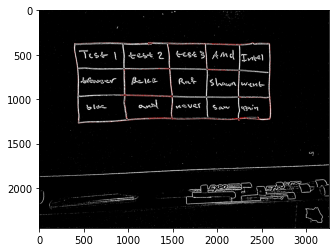

In [6]:
img = cv2.imread("/Users/bekkblando/Documents/github/computer_vision/final_project/Table.jpg", cv2.IMREAD_GRAYSCALE)
# _, threshold = # Binary adaptive threshold using 11 nearest neighbour pixels
processed = pre_process_image(img, True)
ext_contours, _ = cv2.findContours(processed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours, _ = cv2.findContours(processed.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

processed = cv2.cvtColor(processed, cv2.COLOR_GRAY2RGB)

# Draw all of the contours on the image in 2px red lines
# all_contours = cv2.drawContours(processed, contours, -1, (255, 0, 0), 2)
ext_contours = sorted(ext_contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
largest = contours[0]  # Largest image
external_only = cv2.drawContours(processed, ext_contours[0], -1, (255, 0, 0), 2)

plt.imshow(processed)

# [plt.imshow(c[0], processed) for c in [('All Contours', all_contours), ('External Only', external_only)]]

In [7]:
def find_rectangles(img):
    contours, _ = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Draw all of the contours on the image in 2px red lines
    # all_contours = cv2.drawContours(processed, contours, -1, (255, 0, 0), 2)
    #     ext_contours = sorted(ext_contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    #     external_only = 
    rectangles = []
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.01 * peri, True)
        if(len(approx)) == 4:
            rectangles.append(approx)
    return rectangles

def draw_corners(img, corners):
    [cv2.circle(img, tuple(circle), 1, (255, 255, 0), 100) for circle in corners]

[array([399, 371], dtype=int32), array([2596,  375], dtype=int32), array([2597, 1229], dtype=int32), array([ 439, 1270], dtype=int32)]


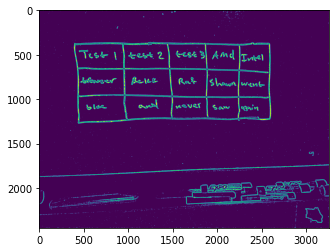

In [8]:
img = cv2.imread('/Users/bekkblando/Documents/github/computer_vision/final_project/Table.jpg', cv2.IMREAD_GRAYSCALE)
processed = pre_process_image(img, True)
corners = find_corners_of_largest_polygon(processed)

# See: https://gist.github.com/mineshpatel1/22e86200eee86ebe3e221343b26fc3f3#file-display_points-py
# cv2.drawContours(processed, corners, -1, (255, 0, 0), 2)
print(corners)
# draw_corners(processed, corners)
corners = find_corners_of_largest_polygon(processed)
plt.imshow(processed)

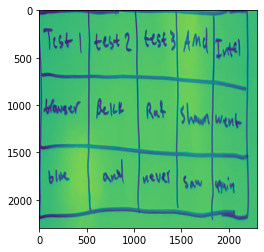

In [9]:
cropped = crop_and_warp(img, corners)
# plt.imshow(cropped)
# [cv2.drawContours(cropped, polygon, ) ]
# for index, polygon in enumerate(sorted(find_rectangles(cropped), key=cv2.contourArea, reverse=True)[:20]):
#     print(index, cv2.contourArea(polygon))
#     cv2.drawContours(cropped, polygon, -1, (0, 255, 0), 300)
plt.imshow(cropped)

In [10]:
def random_color():
    rgbl = [255, 0, 0]
    random.shuffle(rgbl)
    return tuple(rgbl)
random_color()

(0, 0, 255)

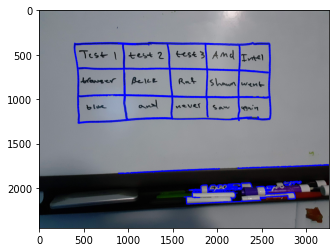

In [11]:
import cv2
import numpy as np

image  = cv2.imread('/Users/bekkblando/Documents/github/computer_vision/final_project/Table.jpg')
# cv2.imshow("Image", image)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# # cv2.imshow("gray", gray)

# blur = cv2.GaussianBlur(gray, (5,5), 0)
# # cv2.imshow("blur", blur)

# thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)
# # cv2.imshow("thresh", thresh)

# contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# max_area = 0
# c = 0
# for i in contours:
#     area = cv2.contourArea(i)
#     if area > 1000:
#         if area > max_area:
#             max_area = area
#             best_cnt = i
#             image = cv2.drawContours(image, contours, c, (0, 255, 0), 3)
#         c+=1

# mask = np.zeros((gray.shape),np.uint8)
# cv2.drawContours(mask,[best_cnt],0,255,-1)
# cv2.drawContours(mask,[best_cnt],0,0,2)
# cv2.imshow("mask", mask)

# out = np.zeros_like(gray)
# out[mask == 255] = gray[mask == 255]
# cv2.imshow("New image", out)
# plt.imshow(out)
# plt.show()

blur = cv2.GaussianBlur(gray, (5,5), 0)
# cv2.imshow("blur1", blur)

thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)
# cv2.imshow("thresh1", thresh)

contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

c = 0
for i in contours:
    area = cv2.contourArea(i)
    if area > 2000:
        peri = cv2.arcLength(i, True)
        approx = cv2.approxPolyDP(i, 0.01 * peri, True)
        if(peri > 1000):
#             print("\n\n\n", approx, "\n\n\n")
            cv2.drawContours(image, contours, c, (0, 0, 255), 8)
    c+=1


plt.imshow(image)


In [15]:
# USAGE
# python text_detection.py --image images/lebron_james.jpg --east frozen_east_text_detection.pb

# import the necessary packages
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2


# load the input image and grab the image dimensions
img = cv2.imread('/Users/bekkblando/Documents/github/computer_vision/final_project/Table.jpg', cv2.IMREAD_GRAYSCALE)
processed = pre_process_image(img, True)
corners = find_corners_of_largest_polygon(processed)


# image = crop_and_warp(cv2.imread(args["image"]), corners)




def detect_text(image):
    orig = cv2.cvtColor(image.copy(), cv2.IMREAD_GRAYSCALE)
    (H, W) = image.shape[:2]
    
    # construct the argument parser and parse the arguments
    args = {
        "width": image.shape[0] - (image.shape[0]%32),
        "height": image.shape[1] - (image.shape[0]%32),
        "east": "/Users/bekkblando/Documents/github/computer_vision/final_project/frozen_east_text_detection.pb",
        "min_confidence": .0001
    }


    # set the new width and height and then determine the ratio in change
    # for both the width and height
    (newW, newH) = (args["width"], args["height"])
    rW = W / float(newW)
    rH = H / float(newH)

    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    # define the two output layer names for the EAST detector model that
    # we are interested -- the first is the output probabilities and the
    # second can be used to derive the bounding box coordinates of text
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]

    # load the pre-trained EAST text detector
    print("[INFO] loading EAST text detector...")
    net = cv2.dnn.readNet(args["east"])

    # construct a blob from the image and then perform a forward pass of
    # the model to obtain the two output layer sets
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
        (123.68, 116.78, 103.94), swapRB=True, crop=False)
    start = time.time()
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    end = time.time()

    # show timing information on text prediction
    print("[INFO] text detection took {:.6f} seconds".format(end - start))

    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < args["min_confidence"]:
                continue

            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    # boxes = non_max_suppression(np.array(rects), probs=confidences)
    boxes = rects

    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)

        # draw the bounding box on the image
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

    # show the output image
    plt.imshow(orig)
    plt.show()
    return rects

In [16]:
def process_and_crop(img, con):
    process = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
    processed = pre_process_image(process, True)
    corners = find_corners_of_largest_polygon(processed)
    # convert image to gray scale image 
    return crop_and_warp(con, corners)

def draw_contours(img):
    gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)

    blur = cv2.GaussianBlur(gray, (5,5), 0)
    # cv2.imshow("blur1", blur)

    thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)
    # cv2.imshow("thresh1", thresh)

    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    bgr = np.zeros((img.shape[0], img.shape[1]), dtype= 'uint8')
    c = 0
    drawn = []
    for i in contours:
        area = cv2.contourArea(i)
        if area > 2000:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.01 * peri, True)
            if(peri > 1000):
                drawn.append(i)
                cv2.drawContours(bgr, contours, c, (255, 0, 0), 5)
        c+=1
    return [bgr, drawn]

In [20]:
def get_lines_p(img):
    edges = cv2.Canny(img,10,50,apertureSize = 7, L2gradient = True)
    cv2.imwrite('edges-50-150.jpg',edges)
    minLineLength=1000

    return cv2.HoughLinesP(image=edges,rho=1,theta=np.pi/2, threshold=100, lines=np.array([]), minLineLength=minLineLength, maxLineGap=500)

def get_lines(img):
    edges = cv2.Canny(img, 100, 200, apertureSize = 3, L2gradient = True)

    lines = cv2.HoughLines(edges,1,np.pi/180,50)
    lines = [line[0] for line in lines]
    return lines

def clean_lines_using_text(img, lines):
    horz, vert = get_lines(img)
    

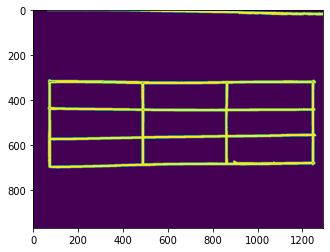

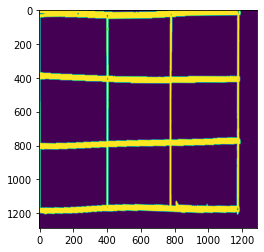

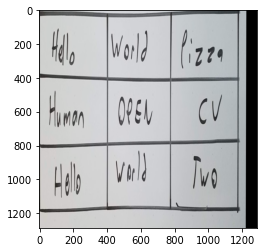

In [21]:
img = cv2.imread("/Users/bekkblando/Documents/github/computer_vision/final_project/CleanTable.jpeg")

# Draw the countours
con, contours = draw_contours(img.copy())
# cv2.drawContours(img, contours, -1, (255, 255, 255), 40)
plt.imshow(con)
plt.show()
# Pre Process and Crop the Image
cropped = process_and_crop(img, con)
plt.imshow(cropped)
plt.show()
# Get the lines

# lines = get_linesp(cropped)
# print(lines.shape)
# a,b,c = lines.shape
# for i in range(a):
#     cv2.line(cropped, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (255, 255, 255), 30, cv2.LINE_AA)

new_img = process_and_crop(img, img)
lines = get_lines(cropped)
line_length = cropped.shape[0]
vertices = []
for rho,theta in lines:
    if(theta < .001 or abs(theta - np.pi/2) < .001):
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        vertices.append((x0, y0))
_vertices = vertices.copy()

for v in vertices:
    for j in _vertices:
        if(v != j and distance_between(v, j) < 160 and j in vertices):
            vertices.remove(j)

# draw_corners(new_img, vertices)

plt.imshow(new_img)
# Get words first try
# Use the words and the lines to evaluate

In [22]:
print(distance_between(vertices[-2], vertices[-1]))

352.00000000000034


In [23]:
y_lines = sorted([vertice[1] for vertice in vertices if vertice[0] < 5])
x_lines = sorted([vertice[0] for vertice in vertices if vertice[1] < 5])

table = []
row = 0
for y_window in range(len(y_lines) - 1):
    table.append([])
    for x_window in range(len(x_lines) - 1):
        # Rectangle described by top left, top right, bottom right and bottom left points
        corners = [(x_lines[x_window], y_lines[y_window]), (x_lines[x_window + 1], y_lines[y_window]), (x_lines[x_window + 1], y_lines[y_window + 1]), (x_lines[x_window], y_lines[y_window + 1])]
        table[row].append(crop_and_warp(new_img, corners))
    row = row + 1
# plt.imshow(new_img)
# plt.show()

In [24]:
y_lines

[428.0, 803.0, 1155.0]

(488, 488, 3)


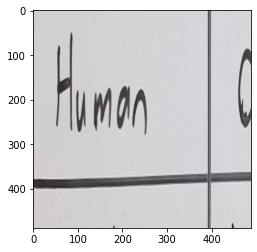

(485, 485, 3)


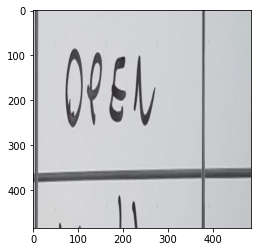

(500, 500, 3)


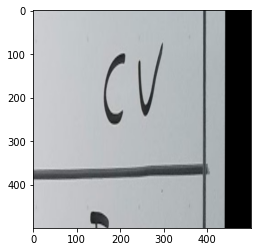

(488, 488, 3)


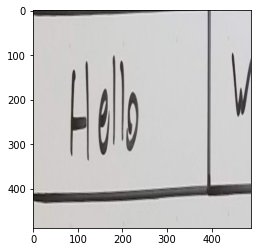

(485, 485, 3)


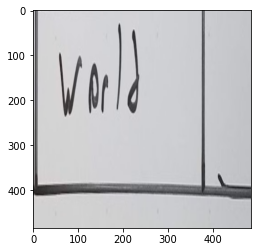

(500, 500, 3)


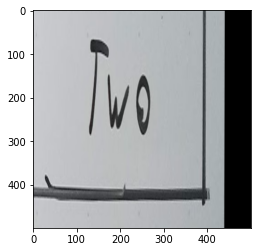

In [25]:
import pytesseract
for row in table:
    for cell in row:
        print(cell.shape)
        plt.imshow(cell)
        plt.show()
#         detect_text(cell)
#         print(pytesseract.image_to_string(cell, config = r'--psm 11 --oem 1'))
# plt.imshow(new_img)
# plt.show()
# print(pytesseract.image_to_string(new_img))

In [26]:
from SimpleHTR.src.main import predict

In [27]:
print(table[0][0].shape)

(488, 488, 3)


In [28]:
import tensorflow as tf
tf.reset_default_graph()
predict(cv2.cvtColor(table[0][0], cv2.COLOR_BGR2GRAY))

W0413 15:10:29.025636 4522927552 module_wrapper.py:139] From /Users/bekkblando/Documents/github/computer_vision/final_project/SimpleHTR/src/Model.py:33: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0413 15:10:29.034598 4522927552 module_wrapper.py:139] From /Users/bekkblando/Documents/github/computer_vision/final_project/SimpleHTR/src/Model.py:67: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0413 15:10:29.042418 4522927552 deprecation.py:323] From /Users/bekkblando/Documents/github/computer_vision/final_project/SimpleHTR/src/Model.py:69: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
W0413 15:10:29.048462

Validation character error rate of saved model: 10.624916%


W0413 15:10:29.422876 4522927552 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0413 15:10:29.850827 4522927552 deprecation.py:323] From /Users/bekkblando/Documents/github/computer_vision/final_project/SimpleHTR/src/Model.py:82: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0413 15:10:29.852197 4522927552 deprecation.py:323] From /Users/bekkblando/Documents/github/computer_vision/final_project/SimpleHTR/src/Model.py:85: MultiRNNCell.__init__ (from tensorflow

Python: 3.7.7 (default, Mar 10 2020, 15:43:03) 
[Clang 11.0.0 (clang-1100.0.33.17)]
Tensorflow: 1.15.0
Init with stored values from SimpleHTR/model/snapshot-38
Recognized: "Lo"
Probability: 0.08402586
